# Modelo

# 1. Carga Inicial de Datos

# Monto

In [ ]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor # New model type!
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 0. Define Paths (re-use existing ones) ---
PATH_OUT = Path("../backend/data/transacciones_para_modelo.parquet")
PATH_CLASSIFIER_MODEL = 'modelo_recurrencia.pkl' # Path to your saved classifier

def prepare_data_for_regression():
    print("=== Preparando datos para modelos de regresión ===")

    # 1. Cargar el DataFrame completo
    df = pd.read_parquet(PATH_OUT)

    # 2. Cargar el modelo clasificador de recurrencia
    classifier_pipeline = joblib.load(PATH_CLASSIFIER_MODEL)
    print(f"Modelo clasificador cargado desde: {PATH_CLASSIFIER_MODEL}")

    # 3. Predecir 'es_recurrente' usando el modelo (para nuevos datos o revalidación)
    # Si 'es_recurrente' ya está en df y fue generada por la lógica actual, podrías usarla directamente.
    # Pero para consistencia y simular un flujo de predicción real, usaremos el modelo.
    # Necesitamos las features para la predicción
    features_for_classifier = [
        "comercio", "giro_comercio", "tipo_venta", "monto",
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio",
        "monto_promedio_comercio", "std_dias_entre_compras",
        "diff_monto_promedio", "monto_similar"
    ]
    features_for_classifier = [f for f in features_for_classifier if f in df.columns]

    df['es_recurrente_pred'] = classifier_pipeline.predict(df[features_for_classifier])

    # 4. Filtrar solo las transacciones predichas como recurrentes
    df_recurrent = df[df['es_recurrente_pred'] == 1].copy()

    if df_recurrent.empty:
        print("No se encontraron transacciones predichas como recurrentes. No se pueden preparar datos para regresión.")
        return None

    # 5. Ordenar por cliente, comercio y fecha para identificar 'siguiente' transacción
    df_recurrent.sort_values(by=['id', 'comercio', 'fecha'], inplace=True)

    # 6. Crear la variable objetivo 'monto_siguiente_recurrente'
    # Shift el monto de la transacción *siguiente* en el mismo grupo id/comercio
    df_recurrent['monto_siguiente_recurrente'] = df_recurrent.groupby(['id', 'comercio'])['monto'].shift(-1)

    # 7. Crear la variable objetivo 'dias_hasta_siguiente_recurrente'
    # Shift la fecha de la transacción *siguiente* y calcular la diferencia en días
    df_recurrent['fecha_siguiente_recurrente'] = df_recurrent.groupby(['id', 'comercio'])['fecha'].shift(-1)
    df_recurrent['dias_hasta_siguiente_recurrente'] = (df_recurrent['fecha_siguiente_recurrente'] - df_recurrent['fecha']).dt.days

    # 8. Eliminar filas donde no hay una 'siguiente' transacción (últimas transacciones de cada serie)
    df_regression = df_recurrent.dropna(subset=['monto_siguiente_recurrente', 'dias_hasta_siguiente_recurrente']).copy()

    print(f"\nDatos preparados para regresión. Filas para entrenamiento: {len(df_regression)}")
    print("Primeras filas del DataFrame para regresión:")
    print(df_regression.head())

    return df_regression

def main_regression_monto(df_regression):
    print("\n=== INICIANDO MODELADO DE REGRESIÓN PARA 'MONTO' ===")

    if df_regression is None or df_regression.empty:
        print("DataFrame de regresión vacío. Saliendo.")
        return

    features_reg = [
        "comercio", "giro_comercio", "tipo_venta", "monto",
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio",
        "monto_promedio_comercio", "std_dias_entre_compras",
        "diff_monto_promedio", "monto_similar"
    ]
    features_reg = [f for f in features_reg if f in df_regression.columns]

    X_reg = df_regression[features_reg]
    y_reg = df_regression['monto_siguiente_recurrente']

    numerical_features_reg = X_reg.select_dtypes(include=np.number).columns.tolist()
    categorical_features_reg = X_reg.select_dtypes(exclude=np.number).columns.tolist()

    preprocessor_reg = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_reg),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_reg)
        ],
        remainder='passthrough'
    )

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg,
        test_size=0.25,
        random_state=42
    )

    # --- Definir el Modelo Base para GridSearchCV ---
    regressor_base = RandomForestRegressor(random_state=42)

    # --- Definir el Pipeline con el preprocesador y el modelo base ---
    pipeline_reg_monto_base = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                              ('regressor', regressor_base)])

    # --- Definir el Espacio de Búsqueda de Hiperparámetros ---
    # Atención: 'regressor__' es el prefijo para los parámetros del paso 'regressor' en el pipeline
    param_grid_monto = {
        'regressor__n_estimators': [100, 200, 300],  # Número de árboles
        'regressor__max_depth': [8, 12, 16],        # Profundidad máxima de los árboles
        'regressor__min_samples_leaf': [3, 5, 7]    # Mínimo de muestras en una hoja
    }

    # Puedes agregar más parámetros o rangos, pero a más opciones, más tiempo de cómputo.
    # Por ejemplo: 'regressor__min_samples_split': [2, 5, 10]

    # --- Configurar GridSearchCV ---
    # Usamos 'neg_mean_absolute_error' porque GridSearchCV busca maximizar la métrica,
    # y queremos minimizar el MAE.
    # n_jobs=-1 usa todos los núcleos de CPU disponibles para acelerar el proceso.
    # cv=3 indica 3-fold cross-validation.
    print("\n--- Iniciando GridSearchCV para optimización del modelo de Monto ---")
    grid_search_monto = GridSearchCV(
        pipeline_reg_monto_base,
        param_grid_monto,
        cv=3,
        scoring='neg_mean_absolute_error', # Para minimizar MAE
        n_jobs=-1,
        verbose=2 # Para ver el progreso
    )

    # --- Entrenar GridSearchCV ---
    grid_search_monto.fit(X_train_reg, y_train_reg)

    print("\n--- GridSearchCV completado. Resultados ---")
    print(f"Mejores parámetros encontrados: {grid_search_monto.best_params_}")
    print(f"Mejor MAE (negativo): {grid_search_monto.best_score_:.4f} -> MAE: {-grid_search_monto.best_score_:.2f}")

    # --- Usar el mejor modelo para la evaluación final ---
    pipeline_reg_monto_optimized = grid_search_monto.best_estimator_
    print("\n--- Evaluación del Modelo de Monto Optimizado ---")
    y_pred_reg_monto = pipeline_reg_monto_optimized.predict(X_test_reg)

    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_monto))
    mae = mean_absolute_error(y_test_reg, y_pred_reg_monto)
    r2 = r2_score(y_test_reg, y_pred_reg_monto)

    print(f"RMSE (Error Cuadrático Medio Raíz): {rmse:.2f}")
    print(f"MAE (Error Absoluto Medio): {mae:.2f}")
    print(f"R-squared: {r2:.4f}")

    # --- Guardar el modelo optimizado ---
    joblib.dump(pipeline_reg_monto_optimized, 'modelo_monto_recurrente_optimizado.pkl')
    print("Modelo de monto recurrente optimizado guardado exitosamente como 'modelo_monto_recurrente_optimizado.pkl'.")

    return pipeline_reg_monto_optimized # Retorna el pipeline optimizado


# --- Main execution flow ---
if __name__ == '__main__':
    # Asegúrate de que esta línea se ejecute solo si necesitas recalcular df_prepared
    # Si ya lo hiciste y el parquet existe, puedes comentar esta línea
    # df_prepared = main_data_preparation()

    # Si ya tienes el parquet, carga directamente para la fase de modelado de clasificación
    # y luego para la de regresión
    # Solo llama a main_model si quieres re-entrenar o re-evaluar el clasificador
    # main_model() # Descomentar si quieres correr el clasificador de nuevo

    # Ahora, prepara los datos para regresión
    df_for_regression = prepare_data_for_regression()

    # Y luego entrena el modelo de monto
    if df_for_regression is not None:
        main_regression_monto(df_for_regression)

    # El modelo de 'cuándo' (días hasta la siguiente transacción) sería similar,
    # pero con 'dias_hasta_siguiente_recurrente' como variable objetivo.
    # Eso lo podemos hacer como un siguiente paso.

=== Preparando datos para modelos de regresión ===
Modelo clasificador cargado desde: modelo_recurrencia.pkl

Datos preparados para regresión. Filas para entrenamiento: 213330
Primeras filas del DataFrame para regresión:
                                          id      fecha comercio  \
5   003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-02-07   AMAZON   
6   003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-02-12   AMAZON   
10  003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-02-28   AMAZON   
14  003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-04-17   AMAZON   
15  003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-04-18   AMAZON   

                                 giro_comercio tipo_venta  monto  \
5   COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital  75.83   
6   COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   
10  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   
14  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   
15  COMERCIOS ELECTRONICOS (VT

# Prueba de Efectividad Monto

Modelo de monto recurrente optimizado cargado exitosamente.
DataFrame 'df_regression' cargado exitosamente desde: ../data/transacciones_para_modelo.parquet
Columna 'fecha' convertida a datetime.

Calculando 'monto_siguiente_recurrente' y 'dias_hasta_siguiente_recurrencia'...
Columnas 'monto_siguiente_recurrente' y 'dias_hasta_siguiente_recurrencia' calculadas.
Modelo clasificador de recurrencia cargado exitosamente.
Columna 'es_recurrente_pred' generada a partir del modelo clasificador.
Filas después de eliminar NaN en 'monto_siguiente_recurrente': 204082

Datos de prueba cargados. Filas para evaluación: 51021
Primeras filas de los datos de prueba (ANTES de preprocesamiento por el pipeline):
            fecha      comercio  \
181766 2022-01-30  MERCADO PAGO   
202487 2022-04-30      7 ELEVEN   
158313 2022-09-09          IZZI   
338706 2022-08-30       7ELEVEN   
316925 2022-04-07       7ELEVEN   

                                           giro_comercio tipo_venta   monto  \
181766   

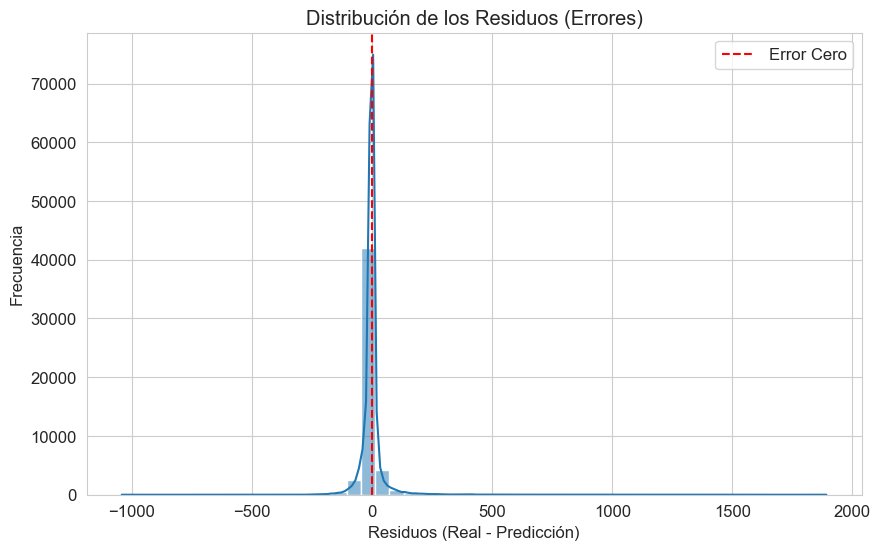

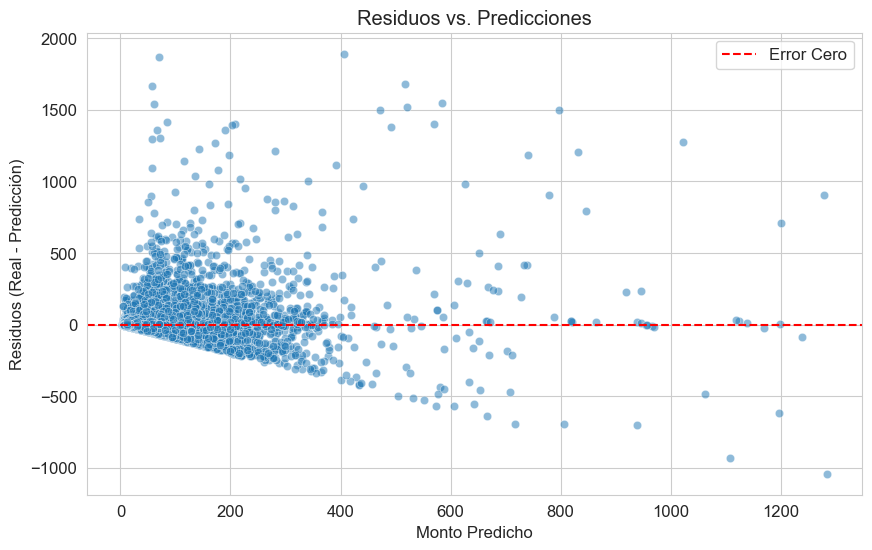

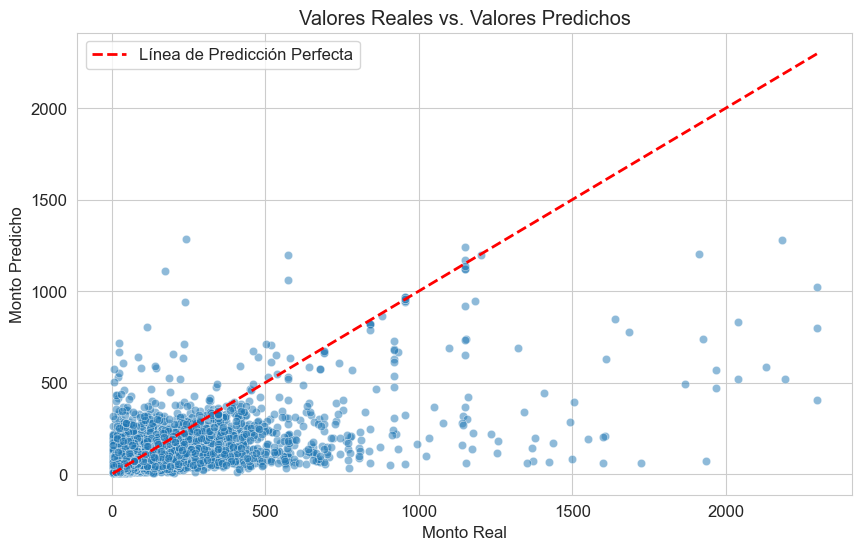


**Análisis de Errores por Rangos de Monto Real:**
              MAE_rango  Std_Error_rango  Mediana_Error_rango  \
monto_rango                                                     
0-50          12.022731        22.644539             4.845273   
51-100        24.107922        28.500503            17.166264   
101-200       51.563278        47.985640            44.629603   
201-500      135.763032        97.670346           128.843984   
501-1000     407.107603       199.850448           421.030946   
>1000        975.392722       477.769732          1003.871676   

             Num_Transacciones  
monto_rango                     
0-50                     41754  
51-100                    5487  
101-200                   2441  
201-500                   1082  
501-1000                   194  
>1000                       63  

RMSE (Error Cuadrático Medio Raíz): 61.25
MAE (Error Absoluto Medio): 20.53
R-squared: 0.4526


/var/folders/rd/d_mznhv14n19s_4d9_h190840000gn/T/ipykernel_57004/2252150292.py:192: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_metrics = df_results.groupby('monto_rango')['error_abs'].agg(['mean', 'std', 'median', 'count'])


In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para gráficos (opcional)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- 1. Cargar el Modelo de Monto Optimizado ---
try:
    pipeline_reg_monto_optimized = joblib.load('modelo_monto_recurrente_optimizado.pkl')
    print("Modelo de monto recurrente optimizado cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo 'modelo_monto_recurrente_optimizado.pkl' no se encontró.")
    print("Asegúrate de que el modelo haya sido guardado en la ruta correcta.")
    exit()

# --- 2. Cargar y Preparar los Datos de Regresión (df_regression) ---
DATA_FILE_PATH = Path("../data/transacciones_para_modelo.parquet")

try:
    df_regression = pd.read_parquet(DATA_FILE_PATH)
    print(f"DataFrame 'df_regression' cargado exitosamente desde: {DATA_FILE_PATH}")
except FileNotFoundError:
    print(f"Error: El archivo '{DATA_FILE_PATH}' no se encontró.")
    print("Asegúrate de que el archivo de datos esté en la ruta correcta.")
    exit()

# Convertir 'fecha' a datetime
if 'fecha' in df_regression.columns:
    df_regression['fecha'] = pd.to_datetime(df_regression['fecha'])
    print("Columna 'fecha' convertida a datetime.")

# --- RECREAR 'monto_siguiente_recurrente' y 'dias_hasta_siguiente_recurrencia' ---
print("\nCalculando 'monto_siguiente_recurrente' y 'dias_hasta_siguiente_recurrencia'...")

df_regression['id_comercio'] = df_regression['id'].astype(str) + '_' + df_regression['comercio'].astype(str)
df_regression = df_regression.sort_values(by=['id_comercio', 'fecha'])

df_regression['monto_siguiente_recurrente'] = df_regression.groupby('id_comercio')['monto'].shift(-1)
df_regression['fecha_siguiente'] = df_regression.groupby('id_comercio')['fecha'].shift(-1)

df_regression.loc[df_regression['es_recurrente'] == False, 'monto_siguiente_recurrente'] = np.nan
df_regression.loc[df_regression['es_recurrente'] == False, 'fecha_siguiente'] = pd.NaT

df_regression['dias_hasta_siguiente_recurrencia'] = (df_regression['fecha_siguiente'] - df_regression['fecha']).dt.days

df_regression.drop(columns=['id_comercio', 'fecha_siguiente'], errors='ignore', inplace=True)
print("Columnas 'monto_siguiente_recurrente' y 'dias_hasta_siguiente_recurrencia' calculadas.")

# --- 3. Cargar el Modelo Clasificador y Generar 'es_recurrente_pred' ---
try:
    modelo_recurrencia = joblib.load('modelo_recurrencia.pkl')
    print("Modelo clasificador de recurrencia cargado exitosamente.")

    features_for_classifier = [
        col for col in df_regression.columns
        if col not in ['id', 'es_recurrente', 'monto_siguiente_recurrente', 'dias_hasta_siguiente_recurrencia']
    ]

    missing_clf_features = [f for f in features_for_classifier if f not in df_regression.columns]
    if missing_clf_features:
        print(f"Error: Faltan las siguientes columnas para el clasificador: {missing_clf_features}")
        exit()

    df_regression['es_recurrente_pred'] = modelo_recurrencia.predict(df_regression[features_for_classifier])
    df_regression['es_recurrente_pred'] = df_regression['es_recurrente_pred'].astype(int)
    print("Columna 'es_recurrente_pred' generada a partir del modelo clasificador.")

except FileNotFoundError:
    print("ADVERTENCIA: El archivo 'modelo_recurrencia.pkl' no se encontró.")
    print("No se pudo cargar el modelo clasificador para generar 'es_recurrente_pred'.")
    print("Asegúrate de que esta columna esté presente en tu archivo .parquet o sea generada de otra forma.")
    exit()

# --- IMPORTANTE: Limpiar filas con NaN *después* de calcular todas las features ---
df_regression.dropna(subset=['monto_siguiente_recurrente'], inplace=True)
print(f"Filas después de eliminar NaN en 'monto_siguiente_recurrente': {len(df_regression)}")


# --- 4. Definir X_reg y y_reg ---
features_reg = [
    'fecha', 'comercio', 'giro_comercio', 'tipo_venta', 'monto',
    'edad_transaccion', 'genero', 'tipo_persona', 'antiguedad_cliente',
    'num_transacciones_previas_comercio', 'monto_promedio_comercio',
    'std_dias_entre_compras',
    'diff_monto_promedio', 'monto_similar', 'es_recurrente_pred',
    'dias_desde_ultima_compra_comercio'
]
target_reg = 'monto_siguiente_recurrente'

missing_features_reg = [f for f in features_reg if f not in df_regression.columns]
if missing_features_reg:
    print(f"Error: Faltan las siguientes columnas para el modelo de regresión: {missing_features_reg}")
    print("Asegúrate de que tu DataFrame de entrada contiene todas las features requeridas.")
    exit()

if target_reg not in df_regression.columns:
    print(f"Error: La columna objetivo '{target_reg}' no se encontró en df_regression DESPUÉS DE RECREARLA.")
    print("Por favor, verifica la lógica de recreación de 'monto_siguiente_recurrente'.")
    exit()

X_reg = df_regression[features_reg]
y_reg = df_regression[target_reg]

# --- 5. Dividir para obtener un conjunto de prueba "fresco" ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.25,
    random_state=42
)

print(f"\nDatos de prueba cargados. Filas para evaluación: {len(X_test_reg)}")
print("Primeras filas de los datos de prueba (ANTES de preprocesamiento por el pipeline):")
print(X_test_reg.head())

# --- 6. Hacer Predicciones ---
print("\nHaciendo predicciones en el conjunto de prueba...")
y_pred_monto = pipeline_reg_monto_optimized.predict(X_test_reg)
print("Predicciones realizadas.")

# --- 7. Evaluación Detallada y Análisis Descriptivo ---

print("\n--- Análisis Descriptivo del Rendimiento del Modelo ---")

# Calcular los residuos (errores)
residuals = y_test_reg - y_pred_monto
abs_residuals = np.abs(residuals)

print(f"\n**Métricas de Errores Absolutos (MAE):**")
print(f"  Promedio del Error Absoluto (MAE): {abs_residuals.mean():.2f}")
print(f"  Desviación Estándar del Error Absoluto: {abs_residuals.std():.2f}")
print(f"  Mediana del Error Absoluto: {abs_residuals.median():.2f}")
print(f"  Percentil 75 del Error Absoluto: {np.percentile(abs_residuals, 75):.2f}")
print(f"  Percentil 95 del Error Absoluto: {np.percentile(abs_residuals, 95):.2f}")
print(f"  Máximo Error Absoluto: {abs_residuals.max():.2f}")

print(f"\n**Métricas de Errores (Residuos, con signo):**")
print(f"  Promedio de los Residuos: {residuals.mean():.2f} (idealmente cercano a 0)")
print(f"  Desviación Estándar de los Residuos (RMSE): {np.sqrt(mean_squared_error(y_test_reg, y_pred_monto)):.2f}")
print(f"  Mediana de los Residuos: {np.median(residuals):.2f}")
print(f"  Percentil 25 de los Residuos: {np.percentile(residuals, 25):.2f}")
print(f"  Percentil 75 de los Residuos: {np.percentile(residuals, 75):.2f}")


# Gráfico 1: Histograma de los errores (residuos)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribución de los Residuos (Errores)')
plt.xlabel('Residuos (Real - Predicción)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error Cero')
plt.legend()
plt.show()

# Gráfico 2: Residuos vs. Valores Predichos (para identificar heterocedasticidad)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_monto, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Error Cero')
plt.title('Residuos vs. Predicciones')
plt.xlabel('Monto Predicho')
plt.ylabel('Residuos (Real - Predicción)')
plt.legend()
plt.show()

# Gráfico 3: Valores Reales vs. Valores Predichos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_monto, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Línea de Predicción Perfecta')
plt.title('Valores Reales vs. Valores Predichos')
plt.xlabel('Monto Real')
plt.ylabel('Monto Predicho')
plt.legend()
plt.show()

# Análisis por rangos de monto real
print("\n**Análisis de Errores por Rangos de Monto Real:**")
df_results = pd.DataFrame({'real': y_test_reg, 'predicho': y_pred_monto, 'error_abs': abs_residuals})

# Define los rangos de monto (ajusta estos rangos según la distribución de tus datos)
bins = [0, 50, 100, 200, 500, 1000, df_results['real'].max() + 100] # Añadir un poco para el max
labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '>1000']
df_results['monto_rango'] = pd.cut(df_results['real'], bins=bins, labels=labels, right=False)

# Calcular métricas por rango
range_metrics = df_results.groupby('monto_rango')['error_abs'].agg(['mean', 'std', 'median', 'count'])
range_metrics = range_metrics.rename(columns={'mean': 'MAE_rango', 'std': 'Std_Error_rango', 'median': 'Mediana_Error_rango', 'count': 'Num_Transacciones'})
print(range_metrics)

print(f"\nRMSE (Error Cuadrático Medio Raíz): {np.sqrt(mean_squared_error(y_test_reg, y_pred_monto)):.2f}")
print(f"MAE (Error Absoluto Medio): {mean_absolute_error(y_test_reg, y_pred_monto):.2f}")
print(f"R-squared: {r2_score(y_test_reg, y_pred_monto):.4f}")

# --- EJEMPLO CON UN SOLO DATO NUEVO (SIMULADO) ---
# ... (Este bloque de código permanece igual que en la última versión)

# Fecha

In [4]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor # Still using for regression!
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 0. Define Paths (re-use existing ones) ---
PATH_TX = Path("../data/transactions_clean.csv")          # Transacciones limpias (desde script Polars)
PATH_CLI = Path("../data/base_clientes_final.csv")         # Clientes
PATH_OUT = Path("../data/transacciones_para_modelo.parquet") # Salida para el modelo
PATH_CLASSIFIER_MODEL = 'modelo_recurrencia.pkl' # Path to your saved classifier


# --- Funciones Auxiliares (mantener las existentes, no se modifican en esta etapa) ---
def calculate_age_at_transaction(birth_date, transaction_date):
    """
    Calculates age (in years) at the time of transaction.
    """
    if pd.isna(birth_date) or pd.isna(transaction_date):
        return None
    if birth_date > transaction_date:
        return 0 # Handle anomaly: birth_date in future
    age = transaction_date.year - birth_date.year - \
          ((transaction_date.month, transaction_date.day) < (birth_date.month, birth_date.day))
    return age

def calculate_customer_seniority_at_transaction(signup_date, transaction_date):
    """
    Calculates customer seniority (in years) at the time of transaction.
    """
    if pd.isna(signup_date) or pd.isna(transaction_date):
        return None
    if signup_date > transaction_date:
        return 0 # Handle anomaly: signup_date in future
    seniority_days = (transaction_date - signup_date).days
    return seniority_days / 365.25

def main_data_preparation():
    print("=== INICIANDO PREPARACIÓN DE DATOS CON PANDAS ===")

    # --- 1. Cargar los datos ---
    try:
        df_clientes = pd.read_csv(PATH_CLI)
        df_transacciones = pd.read_csv(PATH_TX)
    except FileNotFoundError as e:
        print(f"Error: No se encontró el archivo {e.filename}. Verifica las rutas: \nClientes: {PATH_CLI}\nTransacciones: {PATH_TX}")
        return None
    except Exception as e:
        print(f"Ocurrió un error al cargar los archivos CSV: {e}")
        return None

    print("Archivos CSV cargados exitosamente.")

    # --- 2. Preprocesamiento y Conversión de Tipos ---
    # Clientes
    df_clientes['fecha_nacimiento'] = pd.to_datetime(df_clientes['fecha_nacimiento'], errors='coerce')
    df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'], errors='coerce')
    df_clientes['id'] = df_clientes['id'].astype(str)
    df_clientes['genero'] = df_clientes['genero'].fillna('Desconocido')
    df_clientes['tipo_persona'] = df_clientes['tipo_persona'].fillna('Desconocido')

    # Transacciones
    df_transacciones['fecha'] = pd.to_datetime(df_transacciones['fecha'], errors='coerce')
    df_transacciones['id'] = df_transacciones['id'].astype(str)
    df_transacciones['monto'] = pd.to_numeric(df_transacciones['monto'], errors='coerce')

    df_clientes.dropna(subset=['id', 'fecha_nacimiento', 'fecha_alta'], inplace=True)
    df_transacciones.dropna(subset=['id', 'fecha', 'monto'], inplace=True)

    print("\nPreprocesamiento y conversión de tipos completados.")

    # --- 3. Unir DataFrames ---
    cols_clientes_a_usar = ['id', 'fecha_nacimiento', 'fecha_alta', 'genero', 'tipo_persona']
    df_merged = pd.merge(df_transacciones, df_clientes[cols_clientes_a_usar], on='id', how='left')

    df_merged.dropna(subset=['fecha_nacimiento', 'fecha_alta'], inplace=True)
    if df_merged.empty:
        print("Error: El DataFrame fusionado está vacío después de eliminar filas sin 'fecha_nacimiento' o 'fecha_alta'.")
        return None

    print(f"\nDataFrame fusionado. Total de filas: {len(df_merged)}")

    # --- 4. Ingeniería de Características ---
    df_merged['edad_transaccion'] = df_merged.apply(
        lambda row: calculate_age_at_transaction(row['fecha_nacimiento'], row['fecha']), axis=1
    ).astype(float)

    df_merged['antiguedad_cliente'] = df_merged.apply(
        lambda row: calculate_customer_seniority_at_transaction(row['fecha_alta'], row['fecha']), axis=1
    ).astype(float)

    # Rellenar NaNs resultantes de funciones calculate si es necesario (ej. si alguna fecha fue NaT)
    df_merged['edad_transaccion'].fillna(df_merged['edad_transaccion'].median(), inplace=True)
    df_merged['antiguedad_cliente'].fillna(df_merged['antiguedad_cliente'].median(), inplace=True)


    # Ordenar los datos para cálculos de recurrencia basados en series temporales por cliente y comercio
    df_merged.sort_values(['id', 'comercio', 'fecha'], inplace=True)
    print("\nDataFrame ordenado por id, comercio, fecha.")

    # Características de recurrencia (usando shift y expanding para evitar look-ahead bias)
    # `dias_desde_ultima_compra_comercio`
    df_merged['lag_fecha_comercio'] = df_merged.groupby(['id', 'comercio'])['fecha'].shift(1)
    df_merged['dias_desde_ultima_compra_comercio'] = (df_merged['fecha'] - df_merged['lag_fecha_comercio']).dt.days.fillna(9999).astype(int) # Usar un valor grande para la primera compra

    # `num_transacciones_previas_comercio`
    df_merged['num_transacciones_previas_comercio'] = df_merged.groupby(['id', 'comercio']).cumcount()

    # `monto_promedio_comercio` (promedio de montos de transacciones *previas* en el mismo comercio)
    df_merged['monto_promedio_comercio'] = df_merged.groupby(['id', 'comercio'])['monto'].transform(lambda x: x.expanding().mean().shift(1)).fillna(0).astype(float)
    # ^ Se usa shift(1) en expanding() para asegurar que solo se usan datos *previos*

    # `std_dias_entre_compras` (std de los días entre compras *previas* en el mismo comercio)
    df_merged['dias_entre_esta_y_anterior_comercio'] = df_merged.groupby(['id', 'comercio'])['fecha'].diff().dt.days
    df_merged['std_dias_entre_compras'] = df_merged.groupby(['id', 'comercio'])['dias_entre_esta_y_anterior_comercio'].transform(lambda x: x.expanding().std().shift(1)).fillna(0).astype(float)

    # `diff_monto_promedio` (diferencia relativa entre el monto actual y el promedio previo)
    df_merged['diff_monto_promedio'] = np.abs(df_merged['monto'] - df_merged['monto_promedio_comercio']) / df_merged['monto_promedio_comercio']
    # Manejar división por cero/infinito si monto_promedio_comercio es 0 o NaN
    df_merged['diff_monto_promedio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_merged['diff_monto_promedio'].fillna(0, inplace=True) # Rellenar con 0 si no hay promedio previo o es 0

    # `monto_similar` (boolean)
    df_merged['monto_similar'] = (df_merged['diff_monto_promedio'] <= 0.2).astype(bool)


    # --- NUEVA DEFINICIÓN DE 'es_recurrente' (Para que el modelo APRENDA) ---
    # La variable objetivo 'es_recurrente' ahora indica si la transacción exhibe
    # un patrón de frecuencia y/o consistencia de monto que sugiera recurrencia,
    # sin ser una definición perfecta que cause data leakage trivial.
    # El modelo Random Forest intentará aprender esta lógica de forma más compleja.

    # Inicializa 'es_recurrente' como False
    df_merged['es_recurrente'] = False

    # Condición principal: No es la primera transacción para ese cliente/comercio
    # y hay un patrón de repetición o consistencia.
    # Esto es crucial para asegurar que la primera compra NUNCA es recurrente.
    base_condition_not_first_purchase = (df_merged['num_transacciones_previas_comercio'] >= 1)

    # Regla 1: Frecuencia y consistencia temporal (similar a una suscripción)
    # Buscamos transacciones que se repiten en intervalos "razonables" y de forma consistente.
    condition_frequent_consistent = (
        (df_merged['dias_desde_ultima_compra_comercio'].between(1, 45)) & # Entre 1 día y 45 días
        (df_merged['std_dias_entre_compras'] <= 15) & # Baja variabilidad en los intervalos de compra
        (df_merged['num_transacciones_previas_comercio'] >= 2) # Al menos 2 previas (tercera compra en adelante)
    )
    df_merged.loc[base_condition_not_first_purchase & condition_frequent_consistent, 'es_recurrente'] = True

    # Regla 2: Agregadores o comercios de "gasto frecuente" con montos similares
    # Esto captura giros donde se espera mucha frecuencia, y el monto es parecido.
    GIROS_GASTO_FRECUENTE = [
        "COMERCIOS ELECTRONICOS (VTAS POR INTERNET)",
        "SERVICIOS DE STREAMING",
        "TELECOMUNICACIONES",
        "RESTAURANTES", # Si consideras restaurantes frecuentes para algunos clientes
        "CAFETERIAS"
    ] # Puedes expandir esta lista con giros que sean recurrentes en tu negocio

    condition_giro_frequent_similar_monto = (
        df_merged['giro_comercio'].isin(GIROS_GASTO_FRECUENTE) &
        (df_merged['dias_desde_ultima_compra_comercio'].between(1, 60)) & # Un rango más amplio de días
        (df_merged['monto_similar']) & # El monto es similar al promedio
        (df_merged['num_transacciones_previas_comercio'] >= 1) # Ya hubo al menos una previa
    )
    df_merged.loc[base_condition_not_first_purchase & condition_giro_frequent_similar_monto, 'es_recurrente'] = True

    # Regla 3: Compras muy frecuentes, aunque no sean "suscripciones" típicas
    # Captura patrones donde la gente compra a menudo del mismo lugar (ej. supermercado semanal).
    condition_very_frequent = (
        (df_merged['dias_desde_ultima_compra_comercio'].between(1, 30)) &
        (df_merged['num_transacciones_previas_comercio'] >= 4) # Al menos 5 compras en total
    )
    df_merged.loc[base_condition_not_first_purchase & condition_very_frequent, 'es_recurrente'] = True

    # Asegurarse de que la primera transacción con un comercio nunca sea recurrente
    # (aunque base_condition_not_first_purchase ya se encarga de esto)
    df_merged.loc[df_merged['num_transacciones_previas_comercio'] == 0, 'es_recurrente'] = False

    df_merged['es_recurrente'] = df_merged['es_recurrente'].astype(bool)

    print("\nIngeniería de características completada.")
    print("Distribución de la variable objetivo 'es_recurrente' (con criterios ajustados):")
    print(df_merged['es_recurrente'].value_counts(normalize=True))


    # --- 5. Seleccionar y Ordenar Columnas Finales ---
    columnas_finales = [
        "id", "fecha", "comercio", "giro_comercio", "tipo_venta", "monto",
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio", # Incluida como feature
        "monto_promedio_comercio", "std_dias_entre_compras",
        "diff_monto_promedio", "monto_similar", # Incluir estas como features para el modelo
        "es_recurrente" # La variable objetivo (con criterios ajustados)
    ]

    df_final = df_merged[columnas_finales].copy()

    # Asegurar los tipos de datos finales
    df_final['id'] = df_final['id'].astype(str)
    df_final['fecha'] = pd.to_datetime(df_final['fecha'])
    df_final['comercio'] = df_final['comercio'].astype(str)
    df_final['giro_comercio'] = df_final['giro_comercio'].astype(str)
    df_final['tipo_venta'] = df_final['tipo_venta'].astype(str)
    df_final['monto'] = df_final['monto'].astype(float)
    df_final['edad_transaccion'] = df_final['edad_transaccion'].astype(float)
    df_final['genero'] = df_final['genero'].astype(str)
    df_final['tipo_persona'] = df_final['tipo_persona'].astype(str)
    df_final['antiguedad_cliente'] = df_final['antiguedad_cliente'].astype(float)
    df_final['dias_desde_ultima_compra_comercio'] = df_final['dias_desde_ultima_compra_comercio'].astype(int)
    df_final['num_transacciones_previas_comercio'] = df_final['num_transacciones_previas_comercio'].astype(int)
    df_final['monto_promedio_comercio'] = df_final['monto_promedio_comercio'].astype(float)
    df_final['std_dias_entre_compras'] = df_final['std_dias_entre_compras'].astype(float)
    df_final['diff_monto_promedio'] = df_final['diff_monto_promedio'].astype(float)
    df_final['monto_similar'] = df_final['monto_similar'].astype(bool)
    df_final['es_recurrente'] = df_final['es_recurrente'].astype(bool)

    print("\nColumnas finales seleccionadas y ordenadas.")

    # --- 6. Guardar como Parquet ---
    try:
        PATH_OUT.parent.mkdir(parents=True, exist_ok=True)
        df_final.to_parquet(PATH_OUT, index=False, engine='pyarrow')
        print(f"\nDataFrame guardado exitosamente como '{PATH_OUT}'")
    except ImportError:
        print("\nError: Necesitas instalar 'pyarrow' para guardar en formato Parquet.")
        print("Puedes instalarlo con: pip install pyarrow")
    except Exception as e:
        print(f"\nOcurrió un error al guardar el archivo Parquet: {e}")

    return df_final

def main_model():
    print("\n=== INICIANDO FASE DE MODELADO CON SCIKIT-LEARN (CLASIFICADOR) ===")

    df = None
    try:
        df = pd.read_parquet(PATH_OUT)
        print(f"Datos cargados exitosamente desde: {PATH_OUT}")
        print(f"Dimensiones del DataFrame: {df.shape}")
        print("Primeras filas:")
        print(df.head())
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en {PATH_OUT}. Asegúrate de que la etapa de preparación de datos se haya ejecutado correctamente.")
        return
    except Exception as e:
        print(f"Ocurrió un error al cargar el archivo Parquet para el modelo: {e}")
        return

    TARGET_COLUMN = 'es_recurrente'

    print(f"\n--- Análisis Exploratorio Básico de '{TARGET_COLUMN}' ---")
    if TARGET_COLUMN not in df.columns:
        print(f"Error: La columna objetivo '{TARGET_COLUMN}' no se encuentra en el DataFrame.")
        return

    print(f"Distribución de la variable objetivo '{TARGET_COLUMN}':")
    print(df[TARGET_COLUMN].value_counts(normalize=True))

    print("\nInformación del DataFrame:")
    df.info()

    numerical_cols_with_na = df[df.select_dtypes(include=np.number).columns].isnull().sum()
    numerical_cols_with_na = numerical_cols_with_na[numerical_cols_with_na > 0].index.tolist()
    if numerical_cols_with_na:
        print(f"\nDetectados NaNs en columnas numéricas: {numerical_cols_with_na}. Rellenando con la mediana.")
        for col in numerical_cols_with_na:
            df[col].fillna(df[col].median(), inplace=True)

    categorical_cols_with_na = df[df.select_dtypes(exclude=np.number).columns].isnull().sum()
    categorical_cols_with_na = categorical_cols_with_na[categorical_cols_with_na > 0].index.tolist()
    if categorical_cols_with_na:
        print(f"\nDetectados NaNs en columnas categóricas: {categorical_cols_with_na}. Rellenando con la moda.")
        for col in categorical_cols_with_na:
            df[col].fillna(df[col].mode()[0], inplace=True)


    # --- 8. Selección de Características (Features) y Variable Objetivo (Target) ---
    features = [
        "comercio", "giro_comercio", "tipo_venta", "monto",
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio",
        "monto_promedio_comercio", "std_dias_entre_compras",
        "diff_monto_promedio", "monto_similar"
    ]

    features = [f for f in features if f in df.columns]

    X = df[features]
    y = df[TARGET_COLUMN].astype(int)

    print(f"\n--- Preparación de Datos para el Modelo ---")
    print(f"Dimensiones de X (features): {X.shape}")
    print(f"Dimensiones de y (target): {y.shape}")

    # --- 9. Preprocesamiento de Características (para Sklearn Pipeline) ---
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    print(f"\nCaracterísticas numéricas identificadas: {numerical_features}")
    print(f"Características categóricas identificadas: {categorical_features}")

    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # --- 10. División de Datos en Entrenamiento y Prueba ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    print(f"\nDimensiones de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Dimensiones de X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"Proporción de '{TARGET_COLUMN}' en y_train:\n{y_train.value_counts(normalize=True)}")
    print(f"Proporción de '{TARGET_COLUMN}' en y_test:\n{y_test.value_counts(normalize=True)}")

    # --- 11. Creación y Entrenamiento del Pipeline del Modelo ---
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=5
    )

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    print("\n--- Entrenando el Modelo Random Forest para Recurrencia ---")
    pipeline.fit(X_train, y_train)
    print("Modelo entrenado exitosamente.")

    # Guardar el modelo clasificador
    import joblib
    joblib.dump(pipeline, 'modelo_recurrencia.pkl')
    print("Modelo de recurrencia guardado exitosamente como 'modelo_recurrencia.pkl'.")

    # --- 12. Evaluación del Modelo ---
    print("\n--- Evaluación del Modelo en el Conjunto de Prueba ---")
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"\nAUC-ROC Score: {auc_score:.4f}")
    except ValueError as e:
        print(f"\nNo se pudo calcular AUC-ROC: {e}. Esto puede pasar si solo una clase está presente en y_true.")

    # --- 12.1. Importancia de las Características ---
    print("\n--- Importancia de las Características del Modelo ---")
    try:
        numerical_feature_names_transformed = numerical_features
        categorical_feature_names_transformed = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
        all_feature_names = list(numerical_feature_names_transformed) + list(categorical_feature_names_transformed)
        importances = pipeline.named_steps['classifier'].feature_importances_
        sorted_importances = sorted(zip(importances, all_feature_names), reverse=True)
        for i, (imp, name) in enumerate(sorted_importances[:15]):
            print(f"{i+1}. {name}: {imp:.4f}")
    except Exception as e:
        print(f"No se pudo obtener la importancia de las características: {e}")
        print("Asegúrate de que 'classifier' es un modelo con attribute 'feature_importances_'.")

def prepare_data_for_regression():
    print("=== Preparando datos para modelos de regresión ===")

    # 1. Cargar el DataFrame completo
    df = pd.read_parquet(PATH_OUT)

    # 2. Cargar el modelo clasificador de recurrencia
    classifier_pipeline = joblib.load(PATH_CLASSIFIER_MODEL)
    print(f"Modelo clasificador cargado desde: {PATH_CLASSIFIER_MODEL}")

    # 3. Predecir 'es_recurrente' usando el modelo (para nuevos datos o revalidación)
    features_for_classifier = [
        "comercio", "giro_comercio", "tipo_venta", "monto",
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio",
        "monto_promedio_comercio", "std_dias_entre_compras",
        "diff_monto_promedio", "monto_similar"
    ]
    features_for_classifier = [f for f in features_for_classifier if f in df.columns]

    df['es_recurrente_pred'] = classifier_pipeline.predict(df[features_for_classifier])

    # 4. Filtrar solo las transacciones predichas como recurrentes
    df_recurrent = df[df['es_recurrente_pred'] == 1].copy()

    if df_recurrent.empty:
        print("No se encontraron transacciones predichas como recurrentes. No se pueden preparar datos para regresión.")
        return None

    # 5. Ordenar por cliente, comercio y fecha para identificar 'siguiente' transacción
    df_recurrent.sort_values(by=['id', 'comercio', 'fecha'], inplace=True)

    # 6. Crear la variable objetivo 'monto_siguiente_recurrente'
    df_recurrent['monto_siguiente_recurrente'] = df_recurrent.groupby(['id', 'comercio'])['monto'].shift(-1)

    # 7. Crear la variable objetivo 'dias_hasta_siguiente_recurrente'
    df_recurrent['fecha_siguiente_recurrente'] = df_recurrent.groupby(['id', 'comercio'])['fecha'].shift(-1)
    df_recurrent['dias_hasta_siguiente_recurrente'] = (df_recurrent['fecha_siguiente_recurrente'] - df_recurrent['fecha']).dt.days

    # 8. Eliminar filas donde no hay una 'siguiente' transacción (últimas transacciones de cada serie)
    df_regression = df_recurrent.dropna(subset=['monto_siguiente_recurrente', 'dias_hasta_siguiente_recurrente']).copy()

    print(f"\nDatos preparados para regresión. Filas para entrenamiento: {len(df_regression)}")
    print("Primeras filas del DataFrame para regresión:")
    print(df_regression.head())

    return df_regression

def main_regression_monto(df_regression):
    print("\n=== INICIANDO MODELADO DE REGRESIÓN PARA 'MONTO' ===")

    if df_regression is None or df_regression.empty:
        print("DataFrame de regresión vacío. Saliendo.")
        return

    features_reg = [
        "comercio", "giro_comercio", "tipo_venta", "monto", # Monto actual es muy importante
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio",
        "monto_promedio_comercio", "std_dias_entre_compras",
        "diff_monto_promedio", "monto_similar"
    ]
    features_reg = [f for f in features_reg if f in df_regression.columns]

    X_reg = df_regression[features_reg]
    y_reg = df_regression['monto_siguiente_recurrente']

    numerical_features_reg = X_reg.select_dtypes(include=np.number).columns.tolist()
    categorical_features_reg = X_reg.select_dtypes(exclude=np.number).columns.tolist()

    preprocessor_reg = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_reg),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_reg)
        ],
        remainder='passthrough'
    )

    # !!! AQUÍ ESTABA EL ERROR: Agregando la división de datos !!!
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg,
        test_size=0.25,
        random_state=42
    )
    # !!! FIN DE LA CORRECCIÓN !!!

    regressor = RandomForestRegressor(
        random_state=42,
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=5
    )

    pipeline_reg_monto = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                         ('regressor', regressor)])

    print("\n--- Entrenando el Modelo Random Forest para Monto ---")
    pipeline_reg_monto.fit(X_train_reg, y_train_reg)
    print("Modelo de monto entrenado exitosamente.")

    print("\n--- Evaluación del Modelo de Monto ---")
    y_pred_reg_monto = pipeline_reg_monto.predict(X_test_reg)

    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_monto))
    mae = mean_absolute_error(y_test_reg, y_pred_reg_monto)
    r2 = r2_score(y_test_reg, y_pred_reg_monto)

    print(f"RMSE (Error Cuadrático Medio Raíz): {rmse:.2f}")
    print(f"MAE (Error Absoluto Medio): {mae:.2f}")
    print(f"R-squared: {r2:.4f}")

    joblib.dump(pipeline_reg_monto, 'modelo_monto_recurrente.pkl')
    print("Modelo de monto recurrente guardado exitosamente como 'modelo_monto_recurrente.pkl'.")

    return pipeline_reg_monto # Return the trained pipeline for further use if needed

def main_regression_cuando(df_regression):
    print("\n=== INICIANDO MODELADO DE REGRESIÓN PARA 'CUÁNDO' (Días hasta la siguiente transacción) ===")

    if df_regression is None or df_regression.empty:
        print("DataFrame de regresión vacío. Saliendo.")
        return

    # Definir las features para el modelo de regresión de cuándo
    # Son las mismas features de la transacción ACTUAL para predecir los DÍAS hasta la SIGUIENTE.
    features_reg = [
        "comercio", "giro_comercio", "tipo_venta", "monto",
        "edad_transaccion", "genero", "tipo_persona", "antiguedad_cliente",
        "dias_desde_ultima_compra_comercio", "num_transacciones_previas_comercio",
        "monto_promedio_comercio", "std_dias_entre_compras", # std_dias_entre_compras será CLAVE aquí
        "diff_monto_promedio", "monto_similar"
    ]
    features_reg = [f for f in features_reg if f in df_regression.columns]

    X_reg = df_regression[features_reg]
    y_reg = df_regression['dias_hasta_siguiente_recurrente']

    # Preprocesamiento (reusar el mismo transformador, ya que las features son las mismas)
    numerical_features_reg = X_reg.select_dtypes(include=np.number).columns.tolist()
    categorical_features_reg = X_reg.select_dtypes(exclude=np.number).columns.tolist()

    preprocessor_reg = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_reg),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_reg)
        ],
        remainder='passthrough'
    )

    # !!! AQUÍ ESTABA EL ERROR: Agregando la división de datos !!!
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg,
        test_size=0.25,
        random_state=42
    )
    # !!! FIN DE LA CORRECCIÓN !!!

    # Modelo de Regresión
    regressor = RandomForestRegressor(
        random_state=42,
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=5
    )

    pipeline_reg_cuando = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                          ('regressor', regressor)])

    print("\n--- Entrenando el Modelo Random Forest para Cuándo ---")
    pipeline_reg_cuando.fit(X_train_reg, y_train_reg)
    print("Modelo de cuándo entrenado exitosamente.")

    # Evaluación del modelo de cuándo
    print("\n--- Evaluación del Modelo de Cuándo ---")
    y_pred_reg_cuando = pipeline_reg_cuando.predict(X_test_reg)

    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_cuando))
    mae = mean_absolute_error(y_test_reg, y_pred_reg_cuando)
    r2 = r2_score(y_test_reg, y_pred_reg_cuando)

    print(f"RMSE (Error Cuadrático Medio Raíz): {rmse:.2f} días")
    print(f"MAE (Error Absoluto Medio): {mae:.2f} días")
    print(f"R-squared: {r2:.4f}")

    # Guardar este modelo también
    joblib.dump(pipeline_reg_cuando, 'modelo_cuando_recurrente.pkl')
    print("Modelo de cuándo recurrente guardado exitosamente como 'modelo_cuando_recurrente.pkl'.")

    return pipeline_reg_cuando # Return the trained pipeline

# --- Main execution flow ---
if __name__ == '__main__':
    # Esta línea solo se ejecuta si necesitas recalcular df_prepared
    # Si ya lo hiciste y el parquet existe, puedes comentarla
    # df_prepared = main_data_preparation()

    # Si ya tienes el parquet, carga directamente para la fase de modelado de clasificación
    # y luego para la de regresión.
    # Descomenta main_model() si quieres re-entrenar o re-evaluar el clasificador
    # main_model()

    # Ahora, prepara los datos para regresión (esto carga el clasificador y filtra)
    df_for_regression = prepare_data_for_regression()

    # Y luego entrena el modelo de monto
    if df_for_regression is not None:
        main_regression_monto(df_for_regression)
        # Después de entrenar el modelo de monto, entrena el modelo de cuándo
        main_regression_cuando(df_for_regression)

=== Preparando datos para modelos de regresión ===
Modelo clasificador cargado desde: modelo_recurrencia.pkl

Datos preparados para regresión. Filas para entrenamiento: 213330
Primeras filas del DataFrame para regresión:
                                          id      fecha comercio  \
5   003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-02-07   AMAZON   
6   003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-02-12   AMAZON   
10  003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-02-28   AMAZON   
14  003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-04-17   AMAZON   
15  003d9abe467a91847d566cf455bd2d7d6c8f7e75 2022-04-18   AMAZON   

                                 giro_comercio tipo_venta  monto  \
5   COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital  75.83   
6   COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   
10  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   
14  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   
15  COMERCIOS ELECTRONICOS (VT

## optimizacion monto

In [ ]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV # Importamos GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer # Importamos make_scorer

# --- Resto de las funciones (calculate_age_at_transaction, calculate_customer_seniority_at_transaction, main_data_preparation, main_model, prepare_data_for_regression) permanecen IGUALES ---
# Asegúrate de que las tengas definidas antes de esta función si estás pegando en un script más grande.

